In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import os
os.chdir('/content/drive/MyDrive/tooth_project')

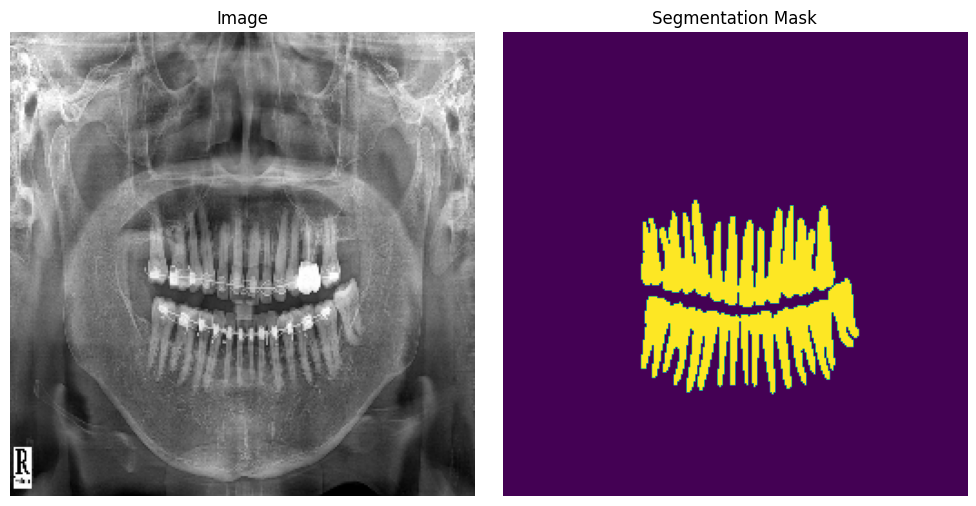

In [56]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

with open('/content/drive/MyDrive/tooth_project/dataset/data1/annotations/instances_default.json') as f:
    coco_data = json.load(f)

categories = coco_data['categories']
images = coco_data['images']
annotations = coco_data['annotations']

category_mapping = {category['id']: category['name'] for category in categories}

image_mapping = {image['id']: image['file_name'] for image in images}

def load_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    return image

def create_segmentation_mask(image_id, width, height, target_size=(256, 256)):
    mask = np.zeros((height, width), dtype=np.uint8)
    for annotation in annotations:
        if annotation['image_id'] == image_id:
            category_id = annotation['category_id']
            value=255
            segmentation = annotation['segmentation']
            for segment in segmentation:
                points = np.array(segment).reshape((-1, 2))
                points = np.int32([points])
                cv2.fillPoly(mask, points, value)

    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    return mask

def visualize_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

example_image_info = images[0]
example_image_path = os.path.join('/content/drive/MyDrive/tooth_project/dataset/data1/images', example_image_info['file_name'])
example_image = load_image(example_image_path, target_size=(256, 256))
example_mask = create_segmentation_mask(example_image_info['id'], example_image_info['width'], example_image_info['height'], target_size=(256, 256))

visualize_image_and_mask(example_image, example_mask)


In [146]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
class CocoSegmentationDataset(Dataset):
    def __init__(self, json_path, image_dir, transform=None):
        self.json_path = json_path
        self.image_dir = image_dir
        self.augs = transform
        with open(json_path, 'r') as f:
            coco_data = json.load(f)

        self.categories = coco_data['categories']
        self.images = coco_data['images']
        self.annotations = coco_data['annotations']

        self.image_mapping = {image['id']: image['file_name'] for image in self.images}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = self.images[idx]
        image_path = os.path.join(self.image_dir, image_info['file_name'])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)

        for annotation in self.annotations:

            if annotation['image_id'] == image_info['id']:
                category_id = annotation['category_id']
                segmentation = annotation['segmentation']
                if category_id>=33:
                  continue
                value=255
                for segment in segmentation:
                    points = np.array(segment).reshape((-1, 2))
                    points = np.int32([points])
                    cv2.fillPoly(mask, points, category_id)
        mask = np.expand_dims(mask, axis=-1)
        # image = np.transpose(image, (2,0,1)).astype(np.float32)
        # mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            mask = torch.max(mask,dim=2)[0]

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")
        # image = np.expand_dims(image, axis=-1)


        # image = torch.Tensor(image)


        return image, mask


In [147]:

import albumentations as A
import torchvision.transforms as T
from albumentations.pytorch import ToTensorV2
t1 = A.Compose([
    A.Resize(512,512),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
# transform=A.Compose([
#     A.Resize(IMG_SIZE, IMG_SIZE),
#     # A.RandomBrightnessContrast(p=0.4),
#     # A.Rotate(limit=10, p=0.2),
#     ], is_check_shapes=False)
# transform = T.Compose([
#     T.ToPILImage(),
#     T.Resize((512,512)),
#     T.ToTensor(),
#     # transforms.Normalize((0.5,), (0.5,))
# ])


In [148]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
# import albumentations as A
# import albumentations.pytorch as APT
from PIL import Image
import json
import os


json_paths = [
    '/content/drive/MyDrive/tooth_project/dataset/data1/annotations/instances_default.json',
    '/content/drive/MyDrive/tooth_project/dataset/data2/annotations/instances_default.json',
    '/content/drive/MyDrive/tooth_project/dataset/data3/annotations/instances_default.json'
]

image_dirs = [
    '/content/drive/MyDrive/tooth_project/dataset/data1/images',
    '/content/drive/MyDrive/tooth_project/dataset/data2/images',
    '/content/drive/MyDrive/tooth_project/dataset/data3/images'
]

datasets = [CocoSegmentationDataset(json_path, image_dir, t1)
            for json_path, image_dir in zip(json_paths, image_dirs)]


combined_dataset = ConcatDataset(datasets)


In [149]:

train_ratio = 0.95
val_ratio = 0.05

total_size = len(combined_dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size
print("train",train_size)
print("val",val_size)
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True,pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False,pin_memory=True)


train 942
val 50


In [150]:
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    unique_values = torch.unique(masks)
    print("Unique values in mask (train):", unique_values)
    break

for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    unique_values = torch.unique(masks)
    print("Unique values in mask (val):", unique_values)
    break

Training batch - Images shape: torch.Size([4, 3, 512, 512]) Masks shape: torch.Size([4, 512, 512])
Unique values in mask (train): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       dtype=torch.uint8)
Validation batch - Images shape: torch.Size([4, 3, 512, 512]) Masks shape: torch.Size([4, 512, 512])
Unique values in mask (val): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
       dtype=torch.uint8)


In [151]:
import json

json_path = '/content/drive/MyDrive/tooth_project/dataset/data1/annotations/instances_default.json'

with open(json_path, 'r') as f:
    coco_data = json.load(f)

categories = coco_data['categories']
# print(coco_data['annotations'])
# total_classes = len(categories)

print("Total classes in the dataset:", categories)


Total classes in the dataset: [{'id': 1, 'name': '11', 'supercategory': ''}, {'id': 2, 'name': '12', 'supercategory': ''}, {'id': 3, 'name': '13', 'supercategory': ''}, {'id': 4, 'name': '14', 'supercategory': ''}, {'id': 5, 'name': '15', 'supercategory': ''}, {'id': 6, 'name': '16', 'supercategory': ''}, {'id': 7, 'name': '17', 'supercategory': ''}, {'id': 8, 'name': '18', 'supercategory': ''}, {'id': 9, 'name': '21', 'supercategory': ''}, {'id': 10, 'name': '22', 'supercategory': ''}, {'id': 11, 'name': '23', 'supercategory': ''}, {'id': 12, 'name': '24', 'supercategory': ''}, {'id': 13, 'name': '25', 'supercategory': ''}, {'id': 14, 'name': '26', 'supercategory': ''}, {'id': 15, 'name': '27', 'supercategory': ''}, {'id': 16, 'name': '28', 'supercategory': ''}, {'id': 17, 'name': '31', 'supercategory': ''}, {'id': 18, 'name': '32', 'supercategory': ''}, {'id': 19, 'name': '33', 'supercategory': ''}, {'id': 20, 'name': '34', 'supercategory': ''}, {'id': 21, 'name': '35', 'supercategor

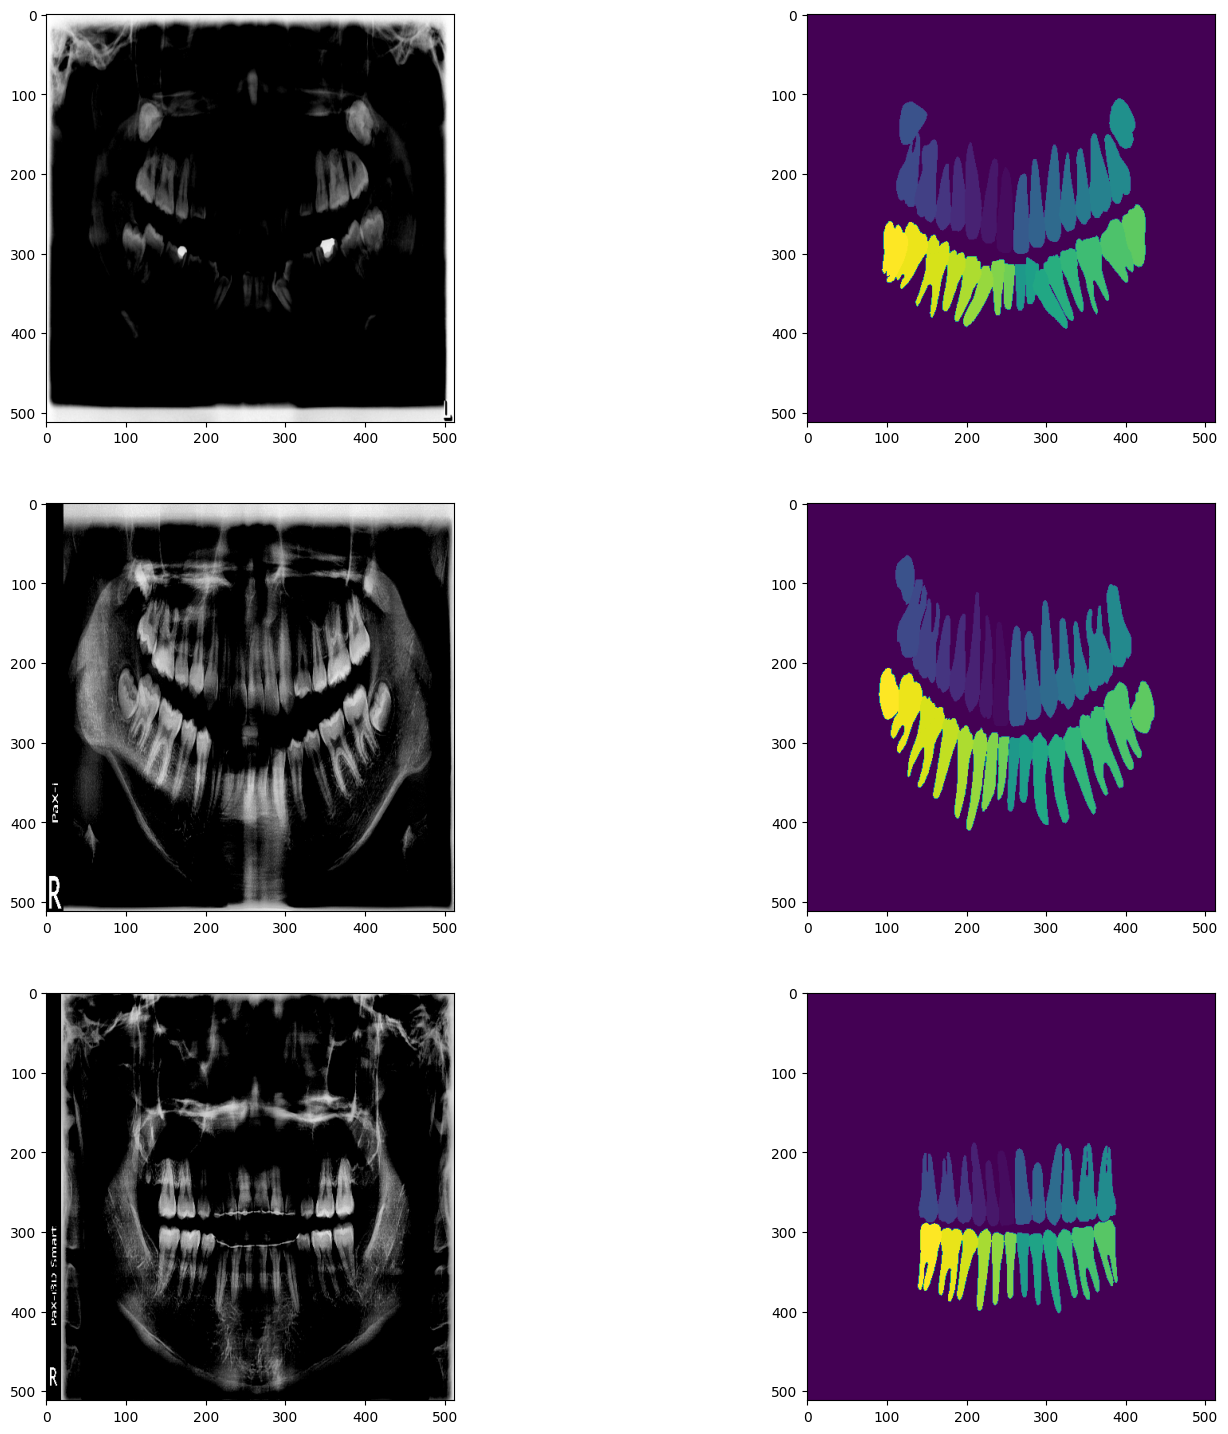

In [152]:
for img,mask in train_dataloader:
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

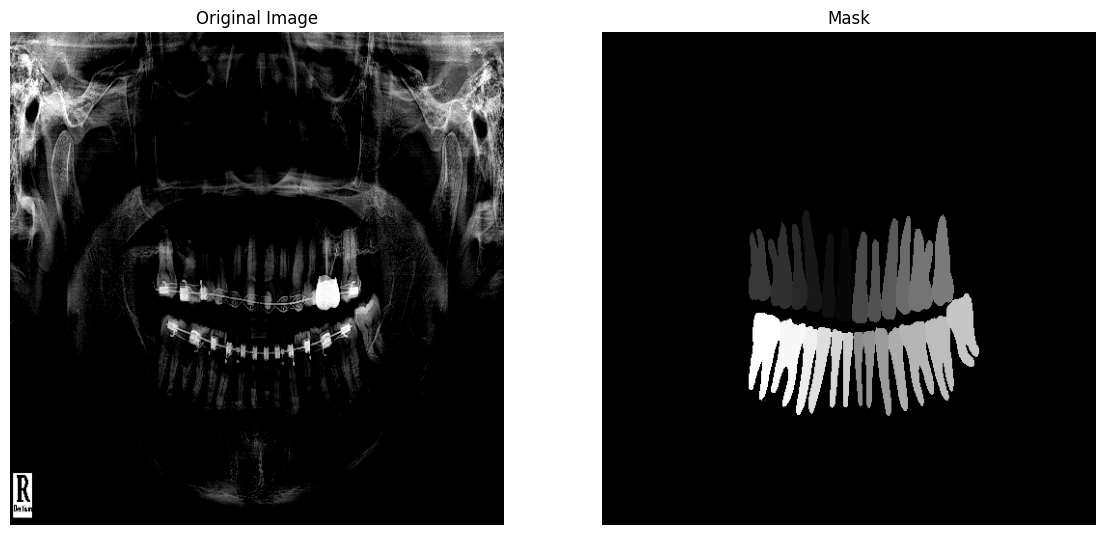

In [153]:
import torch
import numpy as np
import matplotlib.pyplot as plt


image, mask = combined_dataset[0]

image_np = np.array(image).transpose(1, 2, 0)
mask_np = np.array(mask).squeeze()


plt.figure(figsize=(14, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask")
plt.axis('off')

plt.show()


torch.Size([4, 3, 512, 512])


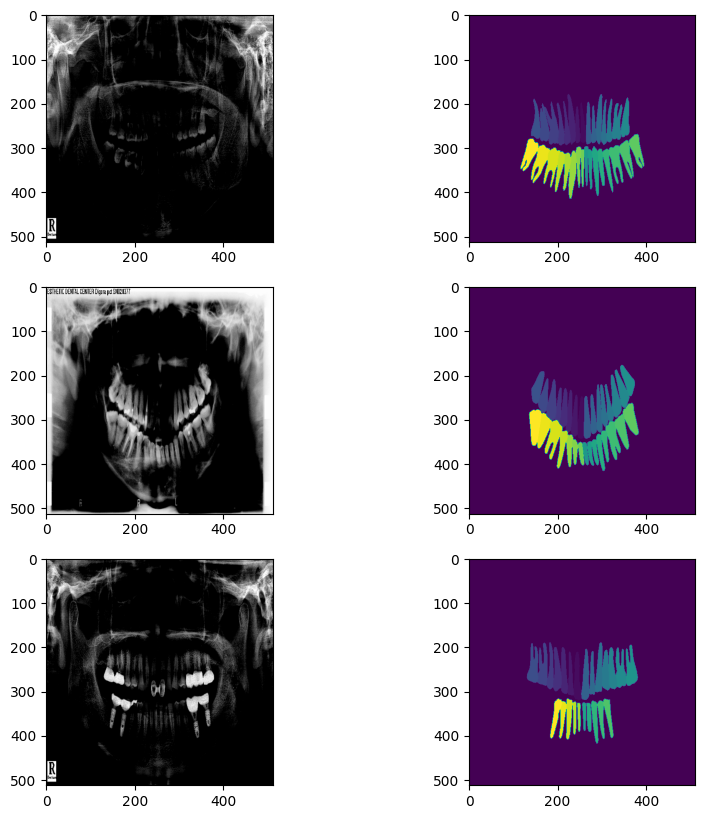

In [154]:
import numpy as np
import matplotlib.pyplot as plt

for img, mask in train_dataloader:
    print(img.shape)
    img1 = np.transpose(img[0], (1, 2, 0))
    mask1 = np.squeeze(mask[0])
    img2 = np.transpose(img[1], (1, 2, 0))
    mask2 = np.squeeze(mask[1])
    img3 = np.transpose(img[2], (1, 2, 0))
    mask3 = np.squeeze(mask[2])

    fig, ax = plt.subplots(3, 2, figsize=(10, 10))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    plt.show()
    break


In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torchvision import transforms
# class encoding_block(nn.Module):
#     def __init__(self,in_channels, out_channels):
#         super(encoding_block,self).__init__()
#         model = []
#         model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
#         model.append(nn.BatchNorm2d(out_channels))
#         model.append(nn.ReLU(inplace=True))
#         model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
#         model.append(nn.BatchNorm2d(out_channels))
#         model.append(nn.ReLU(inplace=True))
#         self.conv = nn.Sequential(*model)
#     def forward(self, x):
#         return self.conv(x)

In [156]:
# class unet_model(nn.Module):
#     def __init__(self,out_channels=33,features=[64, 128, 256, 512]):
#         super(unet_model,self).__init__()
#         self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
#         self.conv1 = encoding_block(3,features[0])
#         self.conv2 = encoding_block(features[0],features[1])
#         self.conv3 = encoding_block(features[1],features[2])
#         self.conv4 = encoding_block(features[2],features[3])
#         self.conv5 = encoding_block(features[3]*2,features[3])
#         self.conv6 = encoding_block(features[3],features[2])
#         self.conv7 = encoding_block(features[2],features[1])
#         self.conv8 = encoding_block(features[1],features[0])
#         self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
#         self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
#         self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
#         self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)
#         self.bottleneck = encoding_block(features[3],features[3]*2)
#         self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
#     def forward(self,x):
#         skip_connections = []
#         x = self.conv1(x)
#         skip_connections.append(x)
#         x = self.pool(x)
#         x = self.conv2(x)
#         skip_connections.append(x)
#         x = self.pool(x)
#         x = self.conv3(x)
#         skip_connections.append(x)
#         x = self.pool(x)
#         x = self.conv4(x)
#         skip_connections.append(x)
#         x = self.pool(x)
#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]
#         x = self.tconv1(x)
#         x = torch.cat((skip_connections[0], x), dim=1)
#         x = self.conv5(x)
#         x = self.tconv2(x)
#         x = torch.cat((skip_connections[1], x), dim=1)
#         x = self.conv6(x)
#         x = self.tconv3(x)
#         x = torch.cat((skip_connections[2], x), dim=1)
#         x = self.conv7(x)
#         x = self.tconv4(x)
#         x = torch.cat((skip_connections[3], x), dim=1)
#         x = self.conv8(x)
#         x = self.final_layer(x)
#         return x

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

class EncodingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncodingBlock, self).__init__()
        model = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        self.conv = nn.Sequential(*model)

    def forward(self, x):
        return self.conv(x)

class UNetModel(nn.Module):
    def __init__(self, out_channels=33, features=[64, 128, 256, 512, 1024]):
        super(UNetModel, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv1 = EncodingBlock(3, features[0])
        self.conv2 = EncodingBlock(features[0], features[1])
        self.conv3 = EncodingBlock(features[1], features[2])
        self.conv4 = EncodingBlock(features[2], features[3])
        self.bottleneck = EncodingBlock(features[3], features[4])  # Added bottleneck with 1024 features

        self.tconv1 = nn.ConvTranspose2d(features[4], features[3], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)

        self.conv5 = EncodingBlock(features[3] * 2, features[3])
        self.conv6 = EncodingBlock(features[2] * 2, features[2])
        self.conv7 = EncodingBlock(features[1] * 2, features[1])
        self.conv8 = EncodingBlock(features[0] * 2, features[0])

        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)

        x = self.bottleneck(x)  # Bottleneck layer with 1024 features

        skip_connections = skip_connections[::-1]  # Reverse skip connections

        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)

        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)

        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)

        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)

        x = self.final_layer(x)
        return x


In [158]:
!pip install torchsummary

In [159]:
model = unet_model()

In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [161]:
from torchsummary import summary
summary(model, (3, 512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,728
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,864
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
    encoding_block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,728
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,456
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [168]:
LEARNING_RATE = 1e-4
num_epochs = 20

In [169]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [170]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_dataloader),total=len(train_dataloader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
    loop.set_postfix(loss=loss.item())
    check_accuracy(train_dataloader, model)
    check_accuracy(val_dataloader, model)

100%|██████████| 236/236 [01:48<00:00,  2.17it/s]


Got 212299385/246939648 with acc 85.97
Dice score: 18.223390579223633
Got 11187665/13107200 with acc 85.36
Dice score: 18.22091293334961


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 224181847/246939648 with acc 90.78
Dice score: 19.690101623535156
Got 11808694/13107200 with acc 90.09
Dice score: 19.485618591308594


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 235104743/246939648 with acc 95.21
Dice score: 19.7994441986084
Got 12359723/13107200 with acc 94.30
Dice score: 19.57880210876465


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 238430690/246939648 with acc 96.55
Dice score: 20.387144088745117
Got 12555389/13107200 with acc 95.79
Dice score: 20.1474552154541


100%|██████████| 236/236 [01:48<00:00,  2.17it/s]


Got 241087895/246939648 with acc 97.63
Dice score: 20.41057777404785
Got 12688680/13107200 with acc 96.81
Dice score: 20.15036392211914


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 242061376/246939648 with acc 98.02
Dice score: 20.540746688842773
Got 12743391/13107200 with acc 97.22
Dice score: 20.300626754760742


100%|██████████| 236/236 [01:47<00:00,  2.19it/s]


Got 242439678/246939648 with acc 98.18
Dice score: 20.665462493896484
Got 12750547/13107200 with acc 97.28
Dice score: 20.42276382446289


100%|██████████| 236/236 [01:47<00:00,  2.19it/s]


Got 242067269/246939648 with acc 98.03
Dice score: 20.578214645385742
Got 12717610/13107200 with acc 97.03
Dice score: 20.332321166992188


100%|██████████| 236/236 [01:47<00:00,  2.19it/s]


Got 242911500/246939648 with acc 98.37
Dice score: 20.68537139892578
Got 12763594/13107200 with acc 97.38
Dice score: 20.427457809448242


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 242974164/246939648 with acc 98.39
Dice score: 20.67892074584961
Got 12764510/13107200 with acc 97.39
Dice score: 20.376298904418945


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243267621/246939648 with acc 98.51
Dice score: 20.781015396118164
Got 12778910/13107200 with acc 97.50
Dice score: 20.5231876373291


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243431290/246939648 with acc 98.58
Dice score: 20.76479721069336
Got 12787884/13107200 with acc 97.56
Dice score: 20.488067626953125


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243732856/246939648 with acc 98.70
Dice score: 20.830015182495117
Got 12801376/13107200 with acc 97.67
Dice score: 20.50547218322754


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243713768/246939648 with acc 98.69
Dice score: 20.851356506347656
Got 12783591/13107200 with acc 97.53
Dice score: 20.468107223510742


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243766307/246939648 with acc 98.71
Dice score: 20.867549896240234
Got 12789324/13107200 with acc 97.57
Dice score: 20.52491569519043


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 244044480/246939648 with acc 98.83
Dice score: 20.89163589477539
Got 12794189/13107200 with acc 97.61
Dice score: 20.444746017456055


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243601182/246939648 with acc 98.65
Dice score: 20.866514205932617
Got 12766536/13107200 with acc 97.40
Dice score: 20.47737693786621


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 243184690/246939648 with acc 98.48
Dice score: 20.685243606567383
Got 12768413/13107200 with acc 97.42
Dice score: 20.365915298461914


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 244155049/246939648 with acc 98.87
Dice score: 20.935941696166992
Got 12802520/13107200 with acc 97.68
Dice score: 20.528278350830078


100%|██████████| 236/236 [01:48<00:00,  2.18it/s]


Got 244300962/246939648 with acc 98.93
Dice score: 20.991302490234375
Got 12796915/13107200 with acc 97.63
Dice score: 20.541641235351562


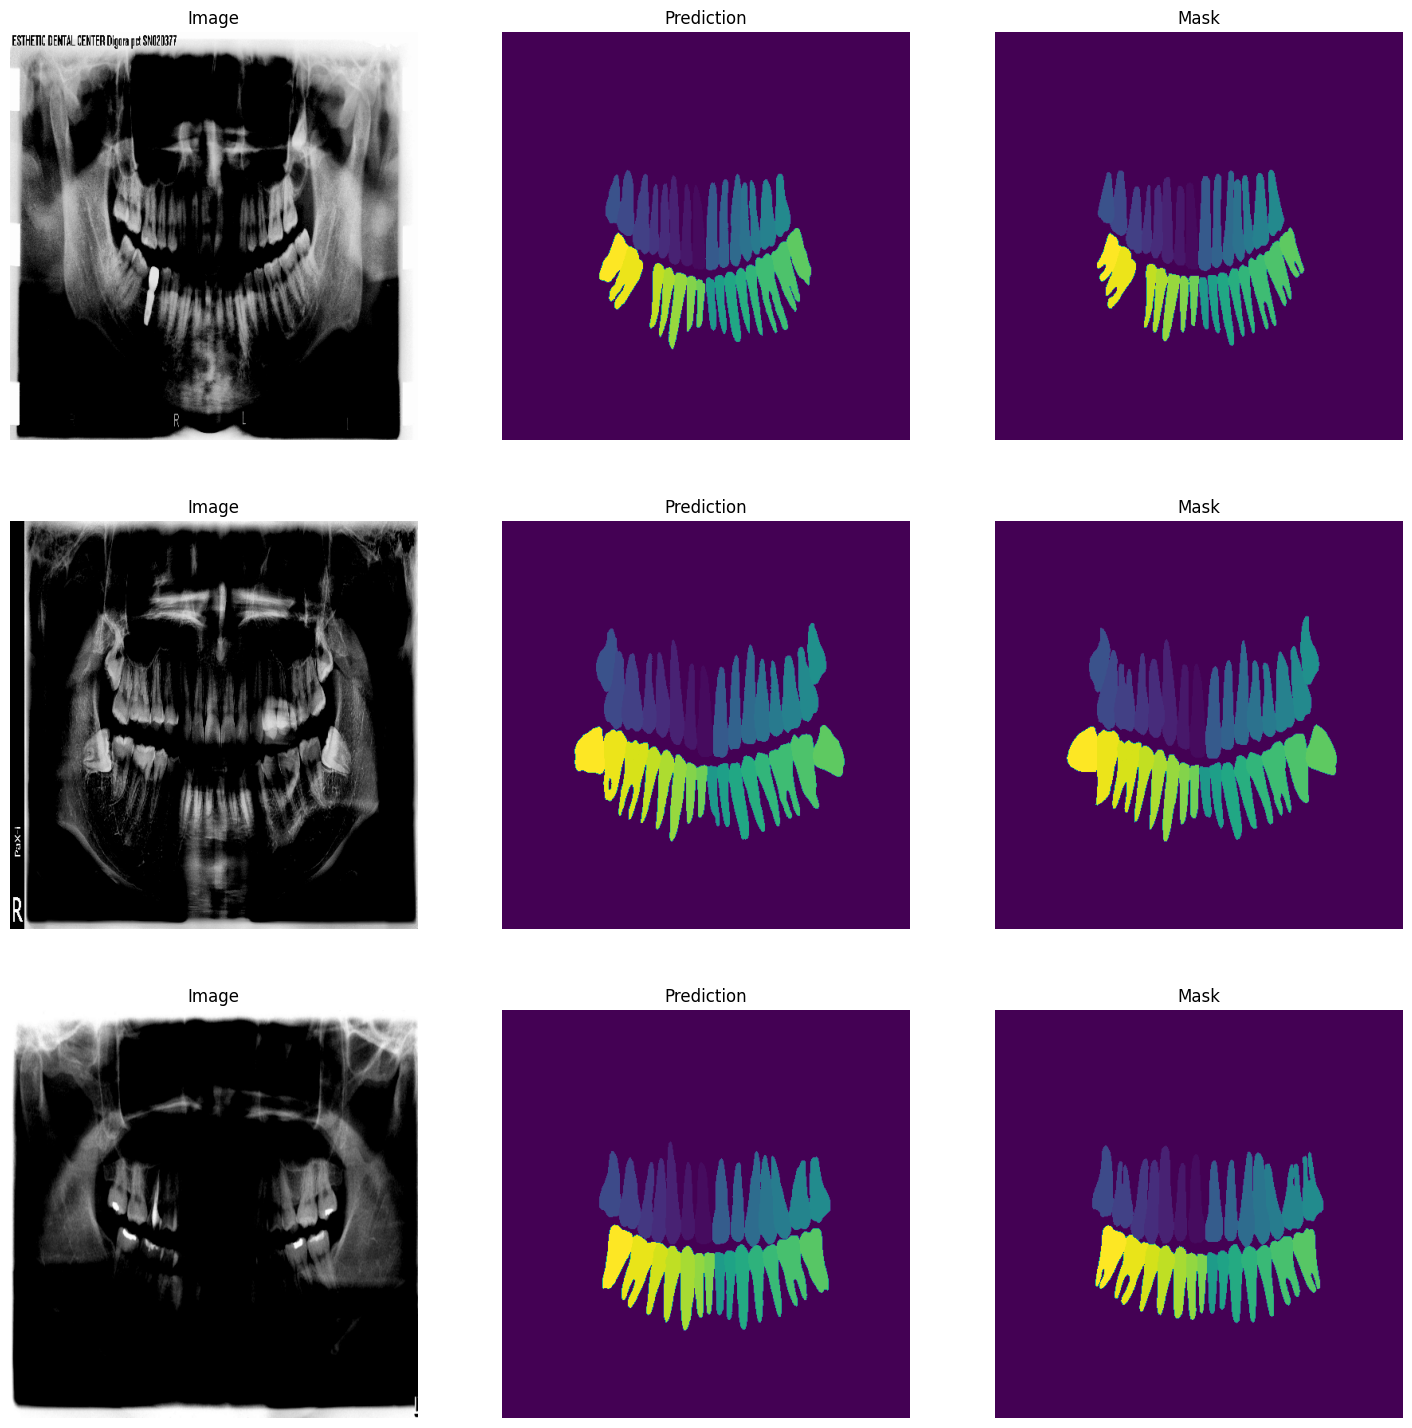

In [171]:
for x,y in val_dataloader:
    x = x.to(device)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)
    break

In [174]:
model_save_path = '/content/drive/MyDrive/tooth_project/tooth_segmentation1.pth'
torch.save(model.state_dict(), model_save_path)

In [175]:
import torch
model_save_path = '/content/drive/MyDrive/tooth_project/tooth_segmentation.pth'

torch.save(model, model_save_path)

In [176]:
import torch
model_save_path = '/content/drive/MyDrive/tooth_project/tooth_segmentation2.pt'

torch.save(model, model_save_path)